In [1]:
#modules
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

from scipy import ndimage


In [2]:
# Functions (export later): 
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.
    
    Refs:
    - https://scitools.org.uk/iris/docs/v1.2/examples/graphics/SOI_filtering.html
    - Duchon C. E. (1979) Lanczos Filtering in One and Two Dimensions.
    Journal of Applied Meteorology, Vol 18, pp 1016-1022.

    """
    order = ((window - 1) / 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([int(nwts)])
    n = int(nwts / 2)
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def LanczosWeights(days,f):
    a=days/2.
    time=np.arange(-days/2,days/2+1,1)
    kernel=np.zeros((len(time)))
    test=np.zeros((len(time)))
    count=-1
    for k in time:
        count=count+1
        if (k >= -a) & (k<=a) ==True: 
            kernel[count] = (np.sin(2*np.pi*k*f)/(k*np.pi))*(np.sin(k*np.pi/a)/(k*np.pi/a))
    kernel[days/2]=2.*f
    return kernel


def LanczosWeightsW(days,f): # automatically uses the largest length of the filter
    ker=100000
    count=0
    add=2.
    for tries in np.arange(1,21):
        count=count+1
        k=LanczosWeights(days+add,f)
        if (np.sum(k[0:add/2.+1]**2))< 1e-30: # find ou how many days the filter can be widened by
            add=add+2
        else:
            ker=LanczosWeights(days+add-2,f)
            ker=ker[(add-2)/2:-(add-2)/2]   
    return ker

def print_ncinfo(dataset):
    for var in dataset.variables:
        var1 = dataset.variables[var]
        for name in var1.ncattrs():
            print var, '-->',name, '=', getattr(var1,name)
            
def runningmean(window1,var,noLanczos,f,ax_no,same_length): 
    """
    window1:Int = length of window (no time intervals) minus 1
    var:Array = variable
    noLanczos:Bool = Lanczos or equal weights
    f:Float = filtering frequency (1/window1)
    ax_no:Int = (time) axis index along which to filter
    same_length:Bool = whether zero-padded (?)
    """
    a=window1/2
    if noLanczos == True:
        weightsR= np.ones(int(window1)+1)/(window1+1.) # Normal filter (equal weights)
    else:
        weightsR=LanczosWeightsWIDE(window1,f)
        # e.g. for 10 day filter should get: [0, 0.01934108,0.06424144, 0.12517813,0.17866529,0.20000000,0.17866529,0.12517813,0.06424144,0.01934108,0]
    v1=convolve_along_axis(variable,a,weightsR/sum(weightsR),ax_no)
    if same_length == True:
        dummy_r = np.zeros((np.shape(v1)))        
        slc = [slice(None)] * len(v1.shape)
        slc[ax_no] = slice(0, a)
        dummy = dummy_r[slc]
        v1 = np.append(dummy,np.append(v1,dummy,axis=ax_no),axis=ax_no)
    return v1

def convolve_along_axis(variable,a,weightsR,ax_no):
    print datetime.datetime.today()
    
    a=int(a)
    v1=scipy.ndimage.filters.convolve1d(variable,weightsR, axis=ax_no,mode='reflect')
    print datetime.datetime.today()
    return v1

def test_filter(switch, var, varS):
    if switch ==True:
        plt.plot(np.arange(0,len(var)), var)
        plt.plot(np.arange(0,len(var)), varS)
        
def append_year_days(fn):
    ncdata =Dataset(fn%1,'r')
    print_ncinfo(ncdata)
    lat = ncdata.variables['lat'][:]
    lon = ncdata.variables['lon'][:]
    sig=ncdata.variables['sigma'][:]
    ncdata.close()
    v = np.zeros((360, len(sig), len(lat), len(lon)))
    u = np.zeros((360, len(sig), len(lat), len(lon)))
    for d_i, d in enumerate(np.arange(1,361)):
        ncdata = Dataset(fn%d,'r')
        v[d_i,:,:,:]=ncdata.variables['v'][:]
        u[d_i,:,:,:]=ncdata.variables['u'][:]
        ncdata.close()
    
    return lat, lon, sig, v, u

In [4]:
# dirs / fnames
day_list = np.arange(1,361)
yr_list = np.arange(1800,5401,360)
print yr_list

depth_ocean_list = [6, 10, 40]
num_fourier_list = [0,3,42]

y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]

data_dir = "/central/scratch/elencz/caltech_fms_idealized/slab_syn_diff/slab_syn_diff_num_fourier_%s_background_m_0.5_background_t_0.5_drag_min_100.e-05_depth_ocean_%s.0_qflux_amp_40.0/output/ppp_output/history"
fname = "day%sh00.segment%s.nc"





[1800 2160 2520 2880 3240 3600 3960 4320 4680 5040 5400]


lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K


lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K


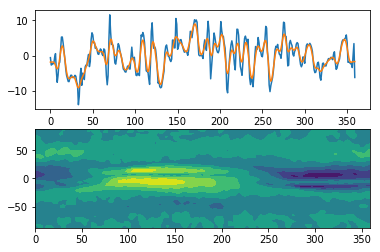

In [5]:
# test filtering
# Lanczos filter
window = 13. # the wider the better (before get -ve weights)
f = 1./10.

wgts11 = low_pass_weights(window, f)  

lat, lon, sig, v, u = append_year_days((data_dir+'/'+fname)%('42', '6', '1800','%s')  )

vB = ndimage.filters.convolve1d(v, wgts11, axis=0,mode='reflect')
vP2 = (v - vB) **2
np.shape(vB)

plt.figure()
plt.subplot(211)
test_filter(True, v[:,1,1,1], vB[:,1,1,1])
plt.subplot(212)
plt.contourf(np.arange(0,360),lat, np.transpose(np.mean(vB[:,1,:,:],axis=-1)))

In [35]:
lat

masked_array(data=[-87.86380005, -85.0965271 , -82.31291199, -79.52560425,
                   -76.73690033, -73.9475174 , -71.15775299, -68.3677597 ,
                   -65.5776062 , -62.78735352, -59.99702072, -57.20663071,
                   -54.41619873, -51.62573242, -48.83523941, -46.04472733,
                   -43.25419617, -40.46364975, -37.67308807, -34.88252258,
                   -32.09194565, -29.30135918, -26.51076889, -23.72017479,
                   -20.92957497, -18.13897133, -15.34836483, -12.55775642,
                    -9.76714516,  -6.97653341,  -4.18592072,  -1.39530694,
                     1.39530694,   4.18592072,   6.97653341,   9.76714516,
                    12.55775642,  15.34836483,  18.13897133,  20.92957497,
                    23.72017479,  26.51076889,  29.30135918,  32.09194565,
                    34.88252258,  37.67308807,  40.46364975,  43.25419617,
                    46.04472733,  48.83523941,  51.62573242,  54.41619873,
                    57.20

In [56]:
# # filtering params
# nyq=0.5 * 1.
# f1 = 1./2.1 /nyq
# f2 = 1./6.5 /nyq
# f3 = 1./30 /nyq

# # calculate parameters for the filtering
# b, a = signal.butter(4, [f2,f1], btype='band')
# b_h, a_h = signal.butter(4, f2, btype='highpass')
# b_l, a_l = signal.butter(4, f2, btype='lowpass')
# b_h_hf, a_h_hf = signal.butter(4, f1, btype='highpass')
# b_l_hf, a_l_hf = signal.butter(4, f1, btype='lowpass')
# b_l_finalfilter, a_l_finalfilter = signal.butter(4, f3, btype='lowpass')

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

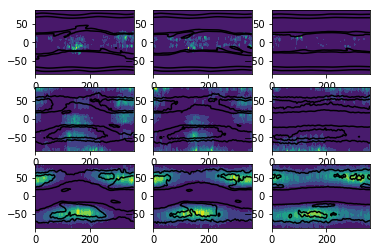

In [8]:
# plot the matrix

# Lanczos filter
window = 13. # the wider the better (before get -ve weights)
f = 1./10.

wgts11 = low_pass_weights(window, f)  

y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]

plt.figure()
ct = 0
for f_i, f in enumerate(num_fourier_list[:]):
    for o_i, o in enumerate(depth_ocean_list[:]):
        ct += 1
        vP2 = 0
        uB = 0
        for y_i, y in enumerate(yr_list):
            lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%(f, o, y,'%s') )
            vB = ndimage.filters.convolve1d(v, wgts11, axis=0,mode='reflect')
            vP2 += (v - vB) **2 / len(yr_list)

            uB += ndimage.filters.convolve1d(u, wgts11, axis=0,mode='reflect') / len(yr_list)
        plt.subplot(len(num_fourier_list), len(depth_ocean_list), ct)
        plt.contourf(np.arange(0,360),lat, np.transpose(np.mean(vP2[:,0,:,:],axis=-1)))
        plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB[:,0,:,:],axis=-1)), [5, 10],colors = 'k')
        
        


lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

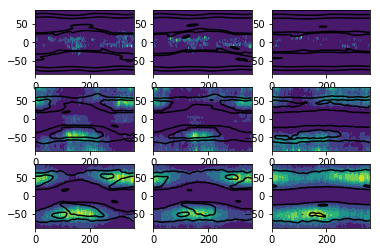

In [9]:
# plot the matrix

# Lanczos filter
window = 33. # the wider the better (before get -ve weights)
f = 1./30.

wgts11 = low_pass_weights(window, f)  

y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]

plt.figure()
ct = 0
for f_i, f in enumerate(num_fourier_list[:]):
    for o_i, o in enumerate(depth_ocean_list[:]):
        ct += 1
        vP2 = 0
        uB = 0
        for y_i, y in enumerate(yr_list):
            lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%(f, o, y,'%s') )
            vB = ndimage.filters.convolve1d(v, wgts11, axis=0,mode='reflect')
            vP2 += (v - vB) **2 / len(yr_list)

            uB += ndimage.filters.convolve1d(u, wgts11, axis=0,mode='reflect') / len(yr_list)
        plt.subplot(len(num_fourier_list), len(depth_ocean_list), ct)
        plt.contourf(np.arange(0,360),lat, np.transpose(np.mean(vP2[:,0,:,:],axis=-1)))
        plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB[:,0,:,:],axis=-1)), [5, 10],colors = 'k')
    

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_name = Equivalent Potential Temperature
pot_temp_eqv --> units = K
lat --> long_name = latitude
lat --> units = degree
lon --> long_name = longitute
lon --> units = degrees_east
sigma --> long_name = sigma level
sigma --> units = none
times --> long_name = number of instants
u --> long_name = Zonal Wind
u --> units = m/s
v --> long_name = Meridional Wind
v --> units = m/s
w --> long_name = Vertical Wind; w = \dot\sigma
w --> units = 1/s
pot_temp --> long_name = Potential Temperature
pot_temp --> units = K
pot_temp_eqv --> long_n

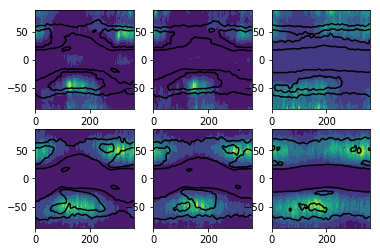

In [31]:
# plot the matrix

# Lanczos filter
window_hf = 9. # the wider the better (before get -ve weights)
f_hf = 1./6.
wgts11_hf = low_pass_weights(window_hf, f_hf)  

window_lf = 19. # the wider the better (before get -ve weights)
f_lf = 1./16.
wgts11_lf = low_pass_weights(window_lf, f_lf)  



y = yr_list[0]
f = num_fourier_list[0]
o = depth_ocean_list[0]

plt.figure()
ct = 0
for f_i, f in enumerate(num_fourier_list[:]):
    for o_i, o in enumerate(depth_ocean_list[:]):
        ct += 1
        vP2_hf = 0
        vP2_lf = 0
        uB = 0
        for y_i, y in enumerate(yr_list):
            lat, lon, sig, v, u = append_year_days( (data_dir+'/'+fname)%(f, o, y,'%s') )
            vB_hf = ndimage.filters.convolve1d(v, wgts11_hf, axis=0,mode='reflect')
            vP2_hf += (v - vB_hf) **2 / len(yr_list)
            vB_lf = ndimage.filters.convolve1d(v, wgts11_lf, axis=0,mode='reflect')
            vP2_lf += (v - vB_lf) **2 / len(yr_list)

            uB += ndimage.filters.convolve1d(u, wgts11_lf, axis=0,mode='reflect') / len(yr_list)
        plt.subplot(len(num_fourier_list), len(depth_ocean_list), ct)
        plt.contourf(np.arange(0,360),lat, np.transpose(np.mean((vP2_lf - vP2_hf)[:,0,:,:],axis=-1)))
        plt.contour(np.arange(0,360),lat, np.transpose(np.mean(uB[:,0,:,:],axis=-1)), [5, 10],colors = 'k')
        